In [34]:
import numpy as np
from pathlib import Path
import pymc as pm
import arviz as az
import multiprocessing as mp
from estival.wrappers import pymc as epm
from estival.sampling import tools as esamp
from estival.wrappers import nevergrad as eng
from estival.utils.parallel import map_parallel
import nevergrad as ng

from tbdynamics.constants import BURN_IN, OPTI_DRAWS
from autumn.infrastructure.remote import springboard
from tbdynamics.model import build_model
from tbdynamics.calib_utils import get_bcm
import pandas as pd

In [ ]:
bcm = get_bcm()

In [2]:
def calibrate(out_path, bcm, draws, tune):
    lhs_samples = bcm.sample.lhs(16)
    lhs_lle = esamp.likelihood_extras_for_samples(lhs_samples, bcm)
    lhs_sorted = lhs_lle.sort_values("loglikelihood", ascending=False)
    start_lhs = lhs_samples[lhs_sorted.index].iloc[0:8]

   
    def optimize_ng(idx_sample):
        idx, sample = idx_sample
        opt = eng.optimize_model(bcm, budget=OPTI_DRAWS, opt_class=ng.optimizers.TwoPointsDE, obj_function=bcm.logposterior, suggested=sample, num_workers=4)
        rec = opt.minimize(OPTI_DRAWS)
        return idx, rec.value[1]

    opt_samples = map_parallel(optimize_ng, start_lhs.iterrows(), n_workers=2, mode='process')
    opt_samples = bcm.sample.convert(opt_samples)
    init_samps = opt_samples.iloc[0:8].convert("list_of_dicts")
    n_chains = 8
    n_samples = 100
    with pm.Model() as pm_model:
        variables = epm.use_model(bcm)
        idata_raw = pm.sample(step=[pm.DEMetropolisZ(variables)], draws=draws, tune=tune, cores=8, discard_tuned_samples=False, chains=n_chains, progressbar=True, initvals=init_samps)
    idata_raw.to_netcdf(str(out_path / 'calib_full_out.nc'))
    
    burnt_idata = idata_raw.sel(draw=np.s_[BURN_IN:])
    idata_extract = az.extract(burnt_idata, num_samples=n_samples)
    bcm.sample.convert(idata_extract).to_hdf5(out_path / 'calib_extract_out.h5')
    
    spaghetti_res = esamp.model_results_for_samples(idata_extract, bcm)
    spaghetti_res.results.to_hdf(str(out_path / 'results.hdf'), 'spaghetti')

    like_df = esamp.likelihood_extras_for_idata(idata_raw, bcm)
    like_df.to_hdf(str(out_path / 'results.hdf'), 'likelihood')

def run_calibration(bridge: springboard.task.TaskBridge, draws, tune):
    import multiprocessing as mp
    mp.set_start_method('forkserver')
    idata_raw = calibrate(bridge.out_path, draws, tune)
    bridge.logger.info('Calibration complete')


In [3]:
OUT_PATH = Path.cwd() / 'runs'

In [4]:
draws= 15000
tune = 3000
calibrate(OUT_PATH, draws, tune)


Multiprocess sampling (8 chains in 8 jobs)
DEMetropolisZ: [start_population_size, contact_rate, rr_infection_latent, rr_infection_recovered, progression_multiplier, seed_time, seed_num, seed_duration, smear_positive_death_rate, smear_negative_death_rate, smear_positive_self_recovery, smear_negative_self_recovery, screening_scaleup_shape, screening_inflection_time, screening_end_asymp]


Sampling 8 chains for 3_000 tune and 15_000 draw iterations (24_000 + 120_000 draws total) took 2043 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [5]:
# draws = 50000
# tune = 10000

# commands = [
#     'git clone https://github.com/longbui/tbdynamics.git',
#     'pip install -r requirements.txt'
#     'pip install -e ./tbdynamics',
# ]

# mspec = springboard.EC2MachineSpec(8, 2, 'compute')
# run_str = f'd{int(draws / 1000)}k-t{int(tune / 1000)}k-b{int(BURN_IN / 1000)}k'
# tspec_args = {'draws': draws, 'tune': tune}
# tspec = springboard.TaskSpec(run_calibration, tspec_args)
# run_path =  ('tbdynamics', 'first_calibration', run_str)
# runner = springboard.launch.launch_synced_autumn_task(tspec, mspec, run_path, branch='tb-calib', extra_commands=commands)
# print(runner.tail())
# runner.wait()
# print(runner.get_iodump())


In [15]:
idata_raw = az.from_netcdf(OUT_PATH /'calib_full_out.nc')

In [16]:
idata = idata_raw.sel(draw=np.s_[BURN_IN:])

In [18]:
lle = esamp.likelihood_extras_for_idata(idata_raw, bcm)

<AxesSubplot: xlabel='draw'>

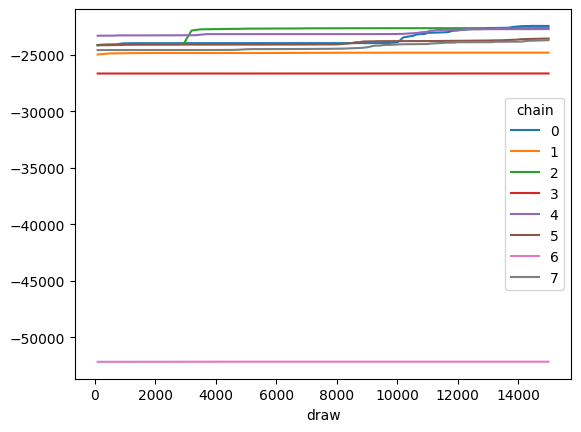

In [19]:
lle["logposterior"].unstack(["chain"]).rolling(100).mean().plot()

In [20]:
burnt_idata = idata_raw.sel(draw=np.s_[BURN_IN:])
idata_extract = az.extract(burnt_idata, num_samples=1000)

In [22]:
spaghetti_res = esamp.model_results_for_samples(idata_extract,bcm)

<AxesSubplot: xlabel='time'>

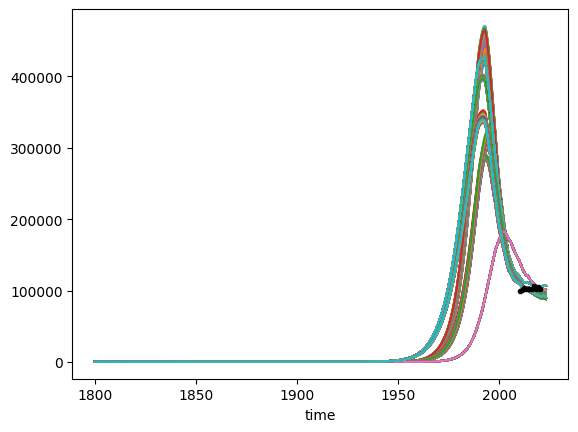

In [39]:
spaghetti_res.results["notification"].plot(legend=False)
bcm.targets["notification"].data.plot(style='.',color="black")

In [27]:
quantiles = esamp.quantiles_for_results(spaghetti_res.results, (0.05,0.25,0.5,0.75,0.95))

<AxesSubplot: xlabel='time'>

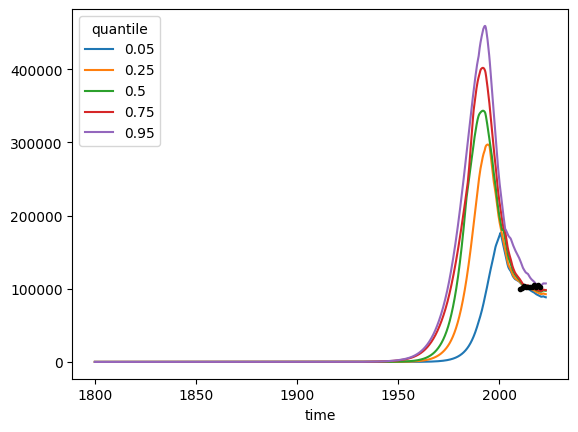

In [28]:
quantiles["notification"].plot()
bcm.targets["notification"].data.plot(style='.',color="black")

<AxesSubplot: xlabel='time'>

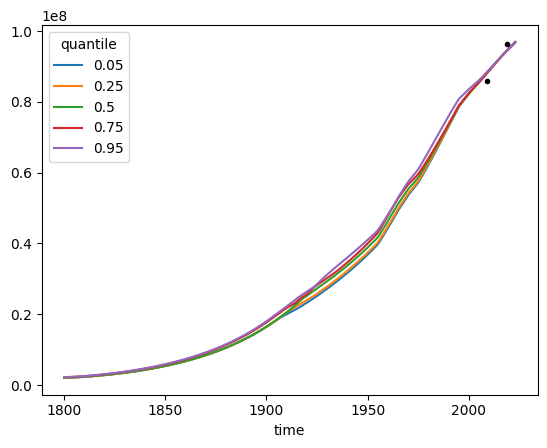

In [29]:
quantiles["total_population"].plot()
bcm.targets["total_population"].data.plot(style='.',color="black")

<AxesSubplot: xlabel='time'>

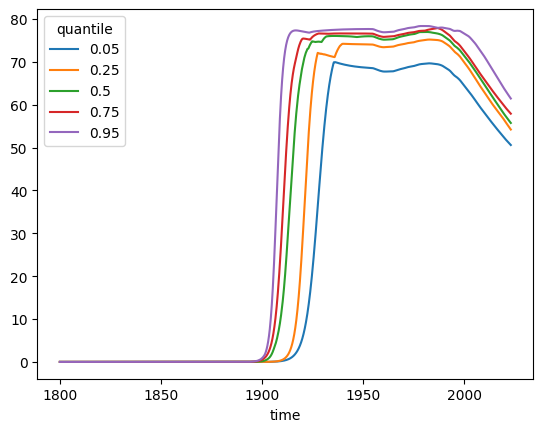

In [31]:
quantiles["percentage_latent"].plot()

<AxesSubplot: xlabel='time'>

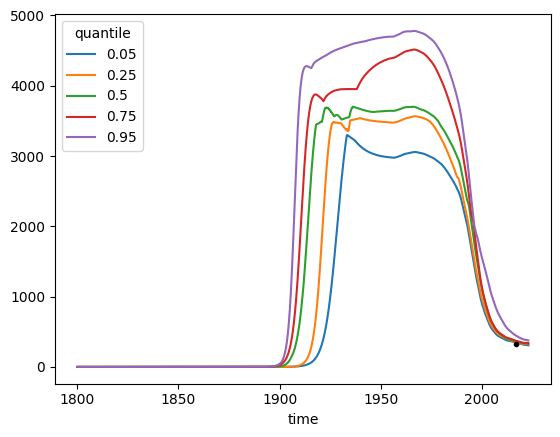

In [32]:
quantiles["prevalence_pulmonary"].plot()
bcm.targets["prevalence_pulmonary"].data.plot(style='.',color="black")